In [3]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/HITMANFOURTY7/ImdbSentimentanalysis-/main/IMDB%20Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     16000 non-null  object
 1   sentiment  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


>Checking for null values:

In [6]:
df.isnull().sum()

,0
review,0
sentiment,0


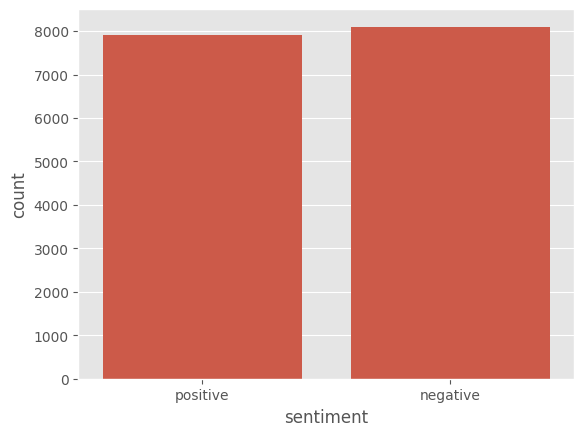

In [7]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [8]:
df["sentiment"].value_counts()

,count
sentiment,
negative,8101
positive,7899


- So, there is no class imbalance both class has an equal number of data.

In [9]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [11]:
try:
    stopwords_list = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stopwords_list = set(stopwords.words('english'))

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [13]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [14]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [15]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

> Creating Embedding Layer:

> An embedding layer is typically used to convert words or tokens from a vocabulary into fixed-length dense vectors, often referred to as word embeddings or word vectors. Each word in the vocabulary is assigned a unique vector representation in the embedding space. These word embeddings are learned through the training process, where the model adjusts the values of the vectors to optimize the task at hand, such as sentiment analysis, machine translation, or text generation

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [18]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

57736

In [19]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [39]:
embedding_dict = dict()
glove_file = open("https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt'

In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2025-06-10 19:12:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-10 19:12:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-10 19:12:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [33]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
import numpy as np

embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 400000 word vectors.


In [35]:
embedding_dim = 100  # Must match glove.6B.100d.txt
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [36]:
from keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=200,
    trainable=False  # Keep False to not update pre-trained vectors
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
import numpy as np

# Ensure the correct file path for the downloaded and unzipped GloVe file
glove_file_path = "glove.6B.100d.txt"

embedding_index = {}
try:
    with open(glove_file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            if len(values) > 1: # Ensure there are enough values
                word = values[0]
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    embedding_index[word] = vector
                except ValueError:
                     # Handle lines that might not be correctly formatted
                    print(f"Skipping line due to formatting error: {line[:50]}...")

except FileNotFoundError:
    print(f"Error: GloVe file not found at '{glove_file_path}'.")
    print("Please ensure you have downloaded and unzipped 'glove.6B.zip' and that 'glove.6B.100d.txt' is in the correct directory.")
    print("You can use the following commands if you haven't already:")
    print("!wget http://nlp.stanford.edu/data/glove.6B.zip")
    print("!unzip glove.6B.zip")
except Exception as e:
    print(f"An error occurred while reading the GloVe file: {e}")


if not embedding_index:
    print("Warning: embedding_index is empty. GloVe embeddings might not have been loaded correctly.")
else:
    print(f"Loaded {len(embedding_index)} word vectors.")

# Now you can use embedding_index (which was named embeddings_dictionary in your previous attempt)
# to build your embedding matrix. Your subsequent code already does this correctly.
# embedding_matrix = np.zeros((vocab_length, 100)) #100
# for word, index in tokenizer.word_index.items():
#     embedding_vector = embedding_index.get(word) # Use embedding_index
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [41]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('would', 7), ('even', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [42]:
embeddings_dictionary.get('film')

In [45]:

print(embedding_index.get('film'))

[ 0.19916  -0.049702  0.24579  -0.32281   0.89768  -0.1278   -0.49506
  0.20814  -0.20046  -0.20604   0.038292 -0.67277  -0.12689  -0.18766
 -0.10277   0.73128   0.82408   0.087288  0.69255   1.3107    0.49113
 -0.38097   0.24338  -0.27813   0.62506   0.35978   0.42041  -0.24529
  0.14861  -0.26726  -0.56262   0.63843  -0.54153   0.36537   0.20545
 -0.16604   0.72434   0.29961  -0.42501  -0.35932  -0.089288  0.48752
 -1.0927    0.88818   0.89941  -0.7541   -0.35492  -0.76396   0.27468
  0.2757   -0.48152  -0.41399   0.64489   1.148    -0.29131  -2.9387
 -0.83162   0.95586   1.1623   -0.42502   0.15486   2.2326   -0.31339
 -0.030228  0.79802  -0.41302   0.72885   0.7296   -0.31909   0.8956
  0.34625   0.2923    0.40056   0.78985  -0.43999   0.24698  -0.46548
  0.055886 -0.62603  -0.036487 -0.65429   0.10563   0.17435   0.35466
 -1.9403   -0.022502 -0.7302   -0.63042  -0.032799 -0.43953  -0.07239
 -0.44875  -0.074689 -0.14426   0.19252   0.27108   0.20325  -0.068109
  0.017651  0.06455 ]

In [46]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [47]:
embedding_matrix.shape

(57736, 100)

> Model Building:
>> Simple Neural Network:

In [48]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,773,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,773,600 (22.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,773,600 (22.02 MB)

In [50]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5082 - val_loss: 0.6931
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5116 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5057 - loss: 0.6931 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5094 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5008 - loss: 0.6933 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5111 - loss: 0.6929 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5117 - loss: 0.6929 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5066 - loss: 0.6931 - val_accuracy: 0.5082 - v

In [51]:
result = snn.evaluate(x_test,y_test, verbose = 1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5122 - loss: 0.6929


In [52]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.4959374964237213
Test Loss: 0.6934518218040466


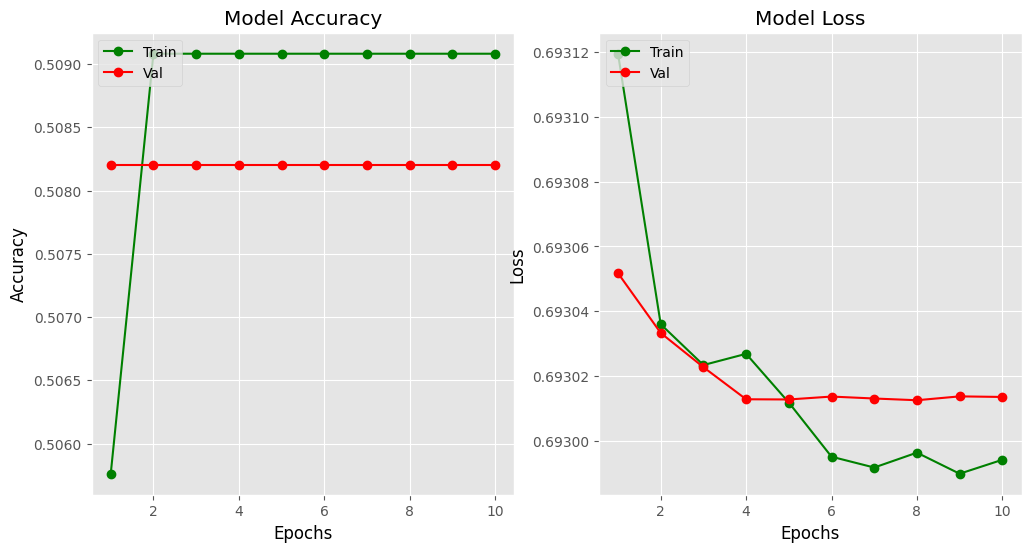

In [53]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> Convolutional Neural Network:

In [54]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [55]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     5,773,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,773,600 (22.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,773,600 (22.02 MB)

In [56]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - accuracy: 0.4968 - loss: 0.6932 - val_accuracy: 0.5082 - val_loss: 0.6931
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 387ms/step - accuracy: 0.5099 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.5084 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.5174 - loss: 0.6927 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.5122 - loss: 0.6929 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.5023 - loss: 0.6932 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 392ms/step - accuracy: 0.5183 - loss: 0.6927 - val_accu

In [57]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5122 - loss: 0.6929
Test Accuracy: 0.4959374964237213
Test Loss: 0.6934460401535034


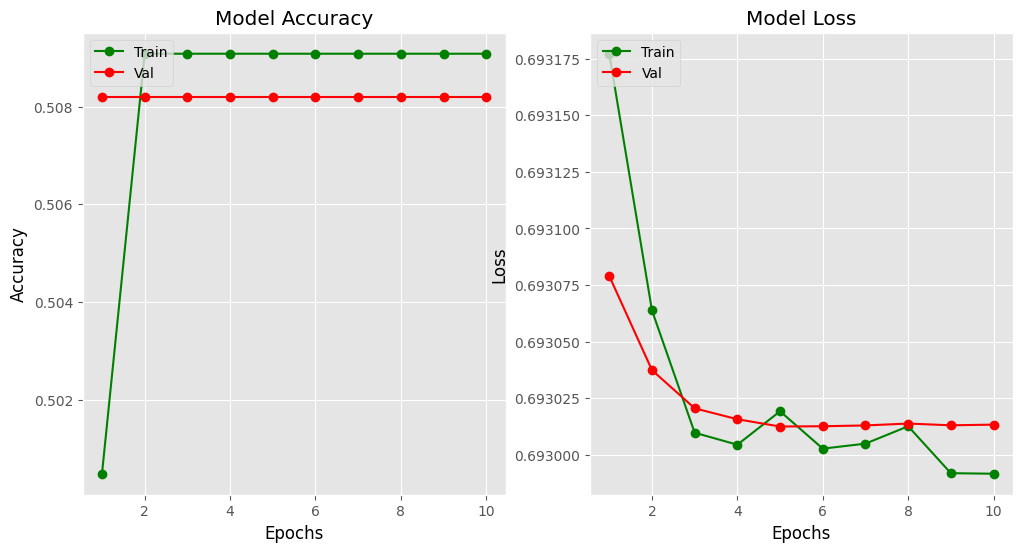

In [58]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> LSTM

In [59]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True
# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))


# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [60]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     5,773,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,773,600 (22.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,773,600 (22.02 MB)

In [61]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 358ms/step - accuracy: 0.5136 - loss: 0.6931 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.5129 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 298ms/step - accuracy: 0.5110 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.5094 - loss: 0.6930 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 296ms/step - accuracy: 0.5130 - loss: 0.6929 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 322ms/step - accuracy: 0.5138 - loss: 0.6929 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 340ms/step - accuracy: 0.5180 - loss: 0.6927 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 335ms/step - accuracy: 0.5139 - loss: 0.6929 - val_accu

In [62]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5122 - loss: 0.6929
Test Accuracy: 0.4959374964237213
Test Loss: 0.6932910680770874


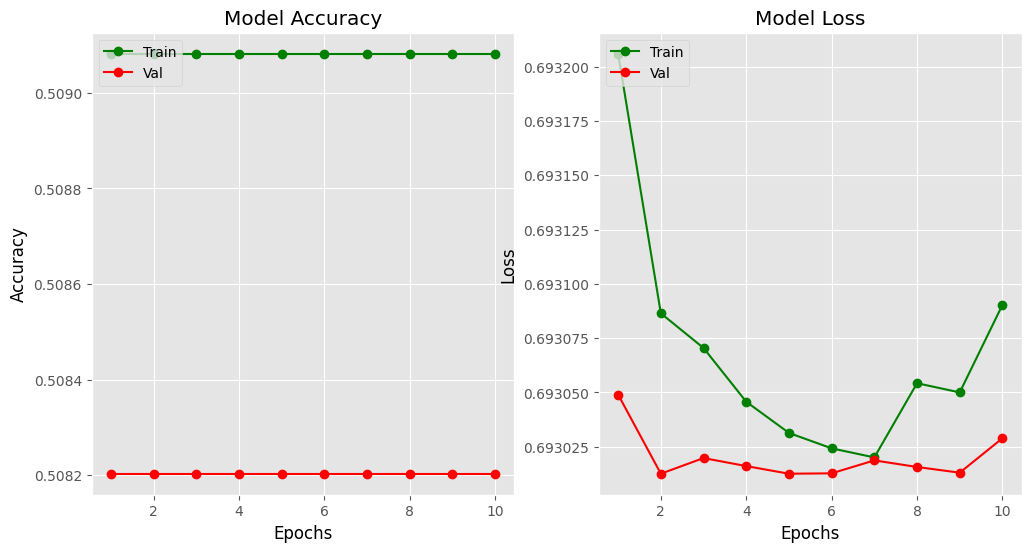

In [63]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [64]:
lstm.save("sentiment_classifier2.h5")